<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/point4/bias_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cloning files needed*

In [78]:
import os
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 504 (delta 39), reused 0 (delta 0), pack-reused 429
Receiving objects: 100% (504/504), 1.31 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (277/277), done.


**Imports**

---

In [0]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
import gc
import seaborn as sns
from sklearn.model_selection import train_test_split



from PIL import Image
from Project_MLDL.confusion_matrix import *
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
from Project_MLDL.model_finetuning import ResNet18
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from tqdm import tqdm

# Garbage collector
gc.enable()

**Arguments**

---





In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 12

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Transformations definition**

---



In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
exemplar_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor() # Turn PIL Image to torch.Tensor
])

*New label function*

In [0]:
DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):     #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
    new_labels=[]
    for el in lbls[:10]:
        new_labels.append(el)
    lbls = lbls[10:]

    return lbls, new_labels

In [0]:
from torch.utils.data import Dataset
"""
Take 2 datasets and combine them
"""
class joint_dataset(Dataset):
    
    def __init__(self,d1,d2):
        self.l1 = len(d1)
        self.l2 = len(d2)
        self.d1 = d1
        self.d2 = d2
        self.targets = [label for image,label in d1]
        self.targets.extend(label for image,label in d2)
        
    def __getitem__(self,index):
        if index>=self.l1:
            image,label = self.d2[index-self.l1]
            image = exemplar_transform(image) # Apply transformations to images
            return image,label
        else:
            image,label = self.d1[index]
            return image,label
    def __len__(self):
        return (self.l1 + self.l2)
    
    def get_targets(self):
        return self.targets

class BiasLayer(nn.Module):
    """ 
    Bias Correction Layer with 2 parameters
    """
    def __init__(self):
        super(BiasLayer, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1, requires_grad=True, device="cuda"))
        self.beta = nn.Parameter(torch.zeros(1, requires_grad=True, device="cuda"))
    def forward(self, x):
        return self.alpha * x + self.beta
    def printParam(self):
        print(self.alpha.item(), self.beta.item())

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
from torch.autograd import Variable

class iCaRL(nn.Module):
  def __init__(self):
    super(iCaRL, self).__init__()

    # CNN with 100 neurons in the last layer (Features Extractor + FC)
    self.net = ResNet18()
    self.net.linear = nn.Linear(512, 100)

    #Bias Layer
    self.bias_layer = BiasLayer().cuda()
    
    # Classification and Distillation losses
    self.cls_loss = nn.BCEWithLogitsLoss()
    self.dist_loss = nn.BCELoss()
    
    self.exemplar_sets=[] # List of exemplar sets, one for each class
    self.exemplars_means=[] # List of exemplar means, one for each exemplar set

  def bias_forward(self,inp,n):
      """
      forward as detailed in the paper:
      apply the bias correction only to the new classes
      """
        out_old = inp[:,:n]
        out_new = inp[:,n:]
        out_new = self.bias_layer(out_new)
        return torch.cat([out_old, out_new], dim = 1)

  def classify(self, x):
    with torch.no_grad():
        net = self.net.eval()
        p = net(x)
        p = self.bias_layer(p).argmax(dim=-1)
        return p

  def reduce_exemplar_sets(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
      m = int(m)
      self.exemplar_sets[y] = P_y[:m] # keep only the first m exemplars
  
  def construct_exemplar_set(self,X,m):
    
    # X dataset containing all elements of class y

    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()

    feature_extractor = self.net.to(DEVICE)
    feature_extractor.train(False)
    loader = DataLoader(X,batch_size=BATCH_SIZE,shuffle=True,drop_last=False,num_workers = 4) # create dataloader

    features = []
    
    for images,labels in loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      feature = feature_extractor.extract_features(images)
      features.append(feature)
      del images
      del labels
      del feature
        
    features_stacked = torch.cat(features) # (num_elements,num_features)
    mean = features_stacked.mean(0) #(num_features)
    mean = torch.stack([mean]*features_stacked.size()[0])  # (num_elements,num_features)
    torch.cuda.empty_cache()
    P = [] # exemplar set
    extracted_features = []

    summa = torch.zeros(1,features_stacked.size()[1]).to(DEVICE) #(1,num_features)
    
    for k in range(1,int(m+1)):
      s = torch.cat([summa]*features_stacked.size()[0]) #(num_elements,num_features)
      index = torch.argmin((mean-(1/k)*(features_stacked+s)).pow(2).sum(1),dim=0)
      features_stacked[index] = features_stacked[index]*100
      pk = X[index.item()][0].unsqueeze(dim=0) # take the image, leave the label
      P.append(pk)
      phipk =  feature_extractor.extract_features(pk.to(DEVICE))
      summa = summa + phipk # update sum of features
      del pk 
   
    #Clear Memory
    del summa
    del features
    del features_stacked
    del mean
    del s
    del feature_extractor
    del loader
    torch.cuda.empty_cache()
    self.exemplar_sets.append(P)
    

  def update_representation(self,X): 
    
    trans = transforms.ToPILImage()
    #Take exemplars
    exemplars_dataset = []
    for i in range(0,len(self.exemplar_sets)):
        for exemplar in self.exemplar_sets[i]:
            exemplar = trans(exemplar.squeeze()).convert("RGB")
            exemplars_dataset.append((exemplar,i)) #append the image in the list with label = index

    D = joint_dataset(X,exemplars_dataset) # Build the dataset 
    
    net = self.net
    inc_i = int(len(self.exemplar_sets)/10)

    #optimizer
    optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
    bias_optimizer = optim.Adam(self.bias_layer.parameters(), lr=0.001)

    # Scheduler for the first part of the network
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

    criterion = self.cls_loss
    criterion2 = self.dist_loss

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    net = net.to(DEVICE)
    
    #Create a Balanced Validation set with stratify
    train_indexes,val_indexes = train_test_split(np.arange(len(D)),stratify=D.get_targets(),test_size = 300)
    img_train = Subset(D, train_indexes)
    img_val = Subset(D, val_indexes)

    # Create Dataloaders 
    loader = DataLoader(img_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    eval_dataloader = DataLoader(img_val, batch_size=10, shuffle=True, num_workers=4, drop_last=False)
    
    if len(self.exemplar_sets)>1:
        old = copy.deepcopy(net) #copy network before training
    
    #Training
    for epoch in range(70):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        # Iterate over the dataset
      for images, labels in loader:
          # Bring data over the device of choice
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          net.train()
        
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)
          # One hot encoding labels for binary cross-entropy loss
          labels_onehot = nn.functional.one_hot(labels,100).type_as(outputs)

          # Compute Loss 
          if len(self.exemplar_sets)==0:
            loss = criterion(outputs, labels_onehot)
          else:
            labels_onehot = labels_onehot.type_as(outputs)[:,len(self.exemplar_sets):]
            out_old = Variable(old(images),requires_grad = False)
            out_old = Variable(torch.sigmoid(out_old)[:,:len(self.exemplar_sets)],requires_grad = False)
            target = torch.cat((out_old,labels_onehot),dim=1)
            loss = criterion(outputs,target)

          if current_step % LOG_FREQUENCY == 0:
              print('Step {}, Loss {}'.format(current_step, loss.item()))

          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients
          current_step += 1
        
      scheduler.step()

    # Training of the bias layer
    if inc_i > 0:
        net.train(False)
        print(f'Training Bias {inc_i}')
        current_step = 0
        epochs = 20
        scheduler_bias = optim.lr_scheduler.MultiStepLR(bias_optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)
        for epoch in range(epochs):
          print('Starting epoch {}/{}, LR = {}'.format(epoch+1, epochs, scheduler_bias.get_last_lr()))

            # Iterate over the dataset
          for images, labels in eval_dataloader:
              # Bring data over the device of choice
              images = images.to(DEVICE)
              labels = labels.to(DEVICE)
              net.train()

              bias_optimizer.zero_grad() # Zero-ing the gradients

              # Forward pass to the network and to the bias layer
              outputs = net(images)
              outputs = self.bias_forward(outputs,len(self.exemplar_sets))

              # One hot encoding labels for binary cross-entropy loss
              labels_onehot = nn.functional.one_hot(labels,100).type_as(outputs)
              
              loss = criterion(outputs, labels_onehot)
    
              if current_step % 10 == 0:
                  print('Step {}, Loss {}'.format(current_step, loss.item()))

              loss.backward()  # backward pass: computes gradients
              bias_optimizer.step() # update weights based on accumulated gradients
              current_step += 1
        scheduler_bias.step()
            
    # Save the trained network and update features extractor
    self.net = copy.deepcopy(net)
    del net
    torch.no_grad()
    torch.cuda.empty_cache()

Files already downloaded and verified
processing batch 1
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.7193732857704163
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.022045446559786797
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.02019474469125271
Starting epoch 4/70, LR = [2]
Starting epoch 5/70, LR = [2]
Step 150, Loss 0.017406757920980453
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.01894366182386875
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.015780283138155937
Starting epoch 8/70, LR = [2]
Starting epoch 9/70, LR = [2]
Step 300, Loss 0.015381651930510998
Starting e

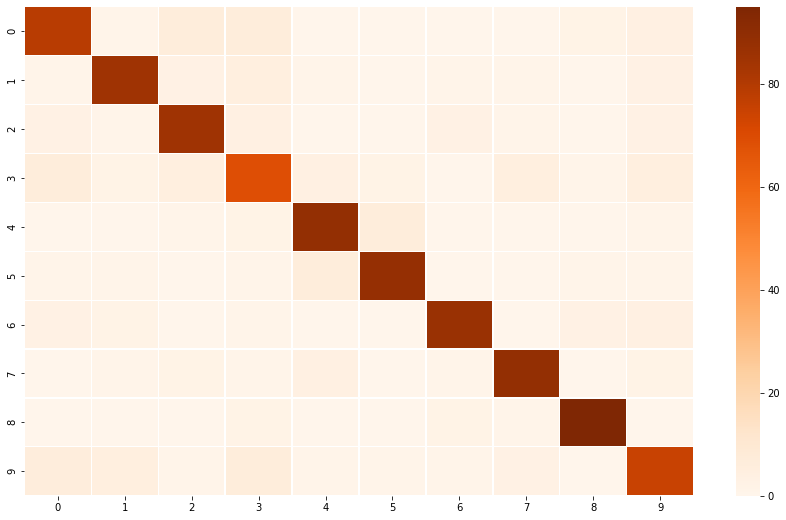

processing batch 2
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.1389961540699005
Step 50, Loss 0.029642626643180847
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.025800051167607307
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.025898227468132973
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.02264365926384926
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.02052120678126812
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.021138686686754227
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.017103366553783417
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.018922628834843636
Starti

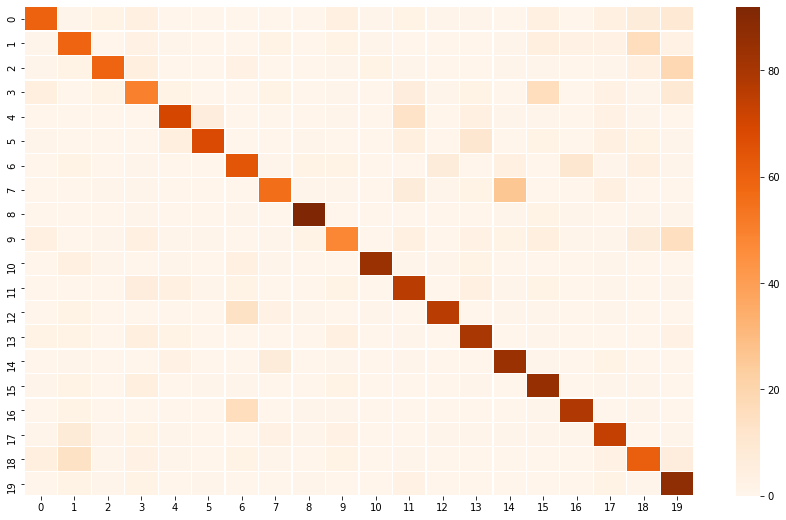

processing batch 3
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.08582041412591934
Step 50, Loss 0.03435702621936798
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.02780352532863617
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.02707185223698616
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.026172326877713203
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.025968747213482857
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.02335808426141739
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.024106992408633232
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.025063548237085342
Startin

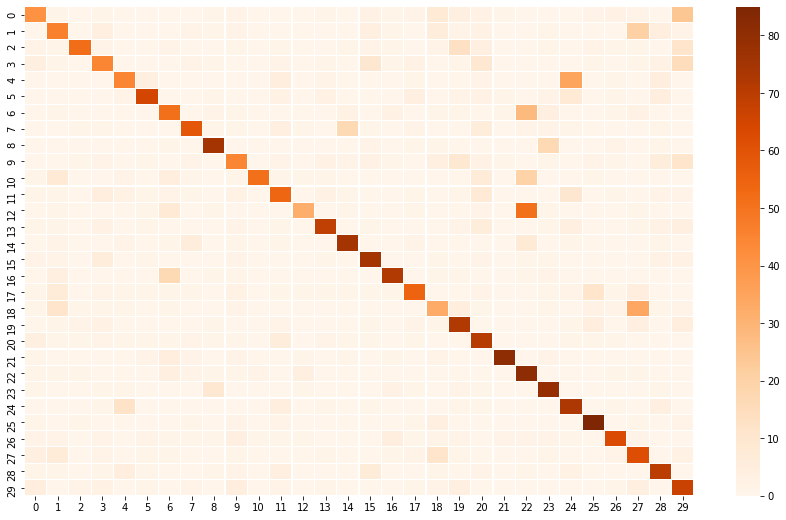

processing batch 4
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.09993915259838104
Step 50, Loss 0.044344134628772736
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.04050825908780098
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.036753471940755844
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.037815921008586884
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.03603124991059303
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.03488908335566521
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.033733826130628586
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.03267133608460426
Startin

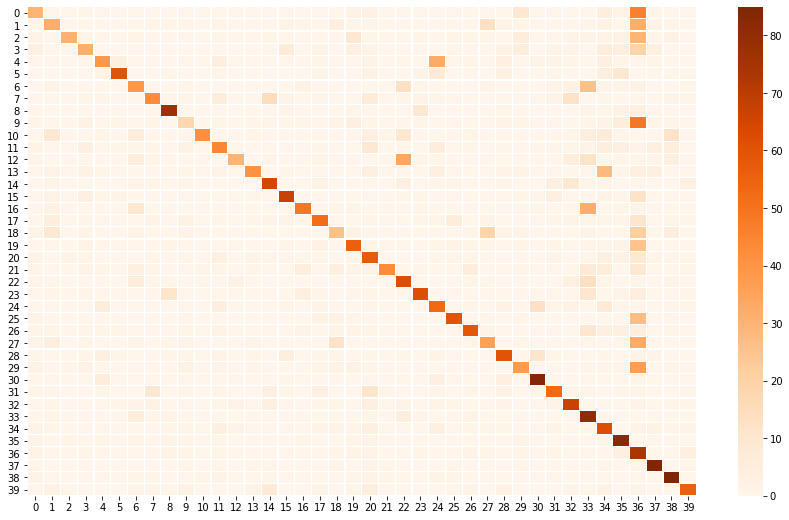

processing batch 5
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.11716576665639877
Step 50, Loss 0.04646613821387291
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.04576952010393143
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.04450180009007454
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.037835072726011276
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.03868701681494713
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.044080767780542374
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.0419578030705452
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.037676312029361725
Starting 

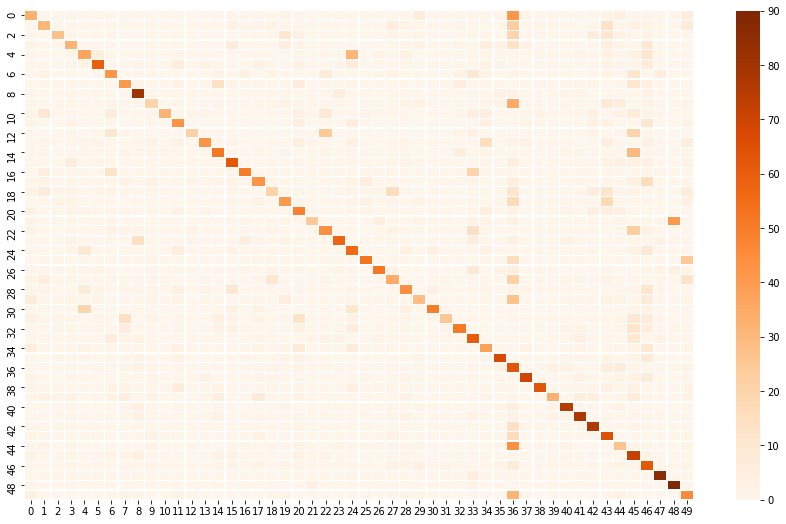

processing batch 6
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12709081172943115
Step 50, Loss 0.055193040519952774
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.05070812255144119
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.048441603779792786
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.047846850007772446
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.044262368232011795
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.04744136705994606
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.04544026777148247
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.039187896996736526
Starti

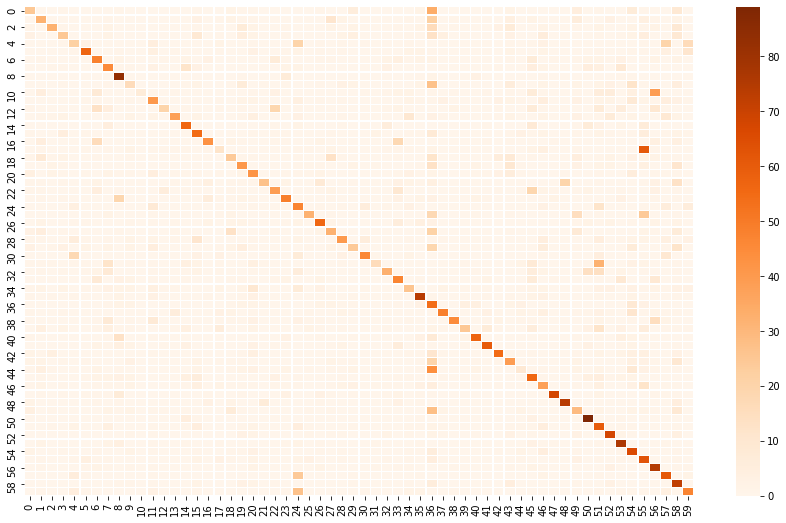

processing batch 7
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.13756471872329712
Step 50, Loss 0.06480614840984344
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06263433396816254
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.057365503162145615
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.060967911034822464
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.05846927687525749
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.059976860880851746
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.05819539725780487
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.05882156640291214
Starting

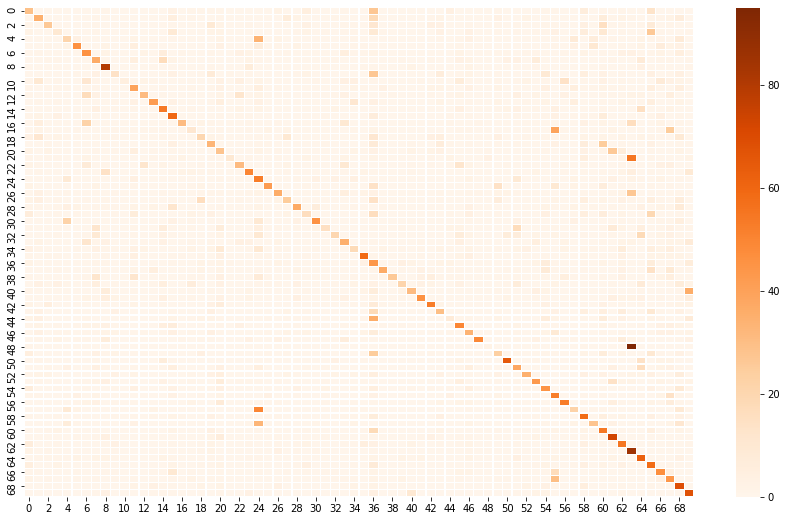

processing batch 8
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.13273897767066956
Step 50, Loss 0.07313729077577591
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06248544156551361
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.07192615419626236
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.059970978647470474
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.06196996569633484
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.06667015701532364
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.0586986243724823
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.06625975668430328
Starting ep

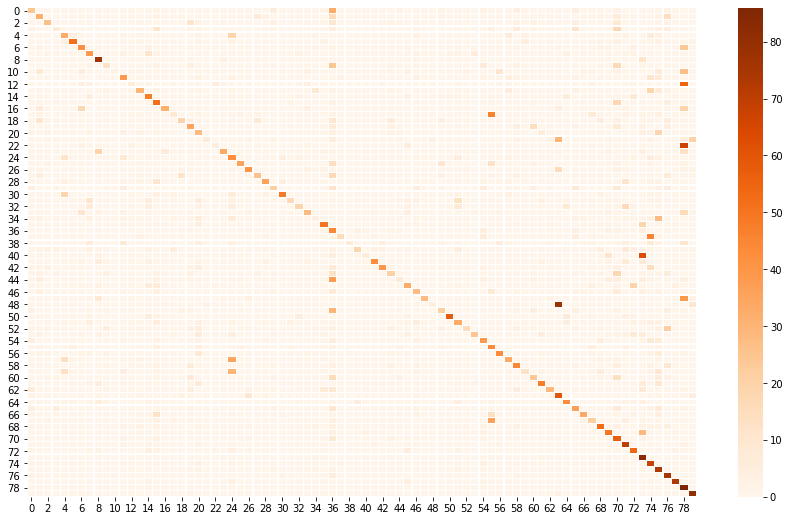

processing batch 9
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.13912799954414368
Step 50, Loss 0.06444583833217621
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06329046189785004
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.06447525322437286
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.0767250508069992
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.06287579238414764
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.06881479173898697
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.0635867565870285
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.05973801016807556
Starting epoc

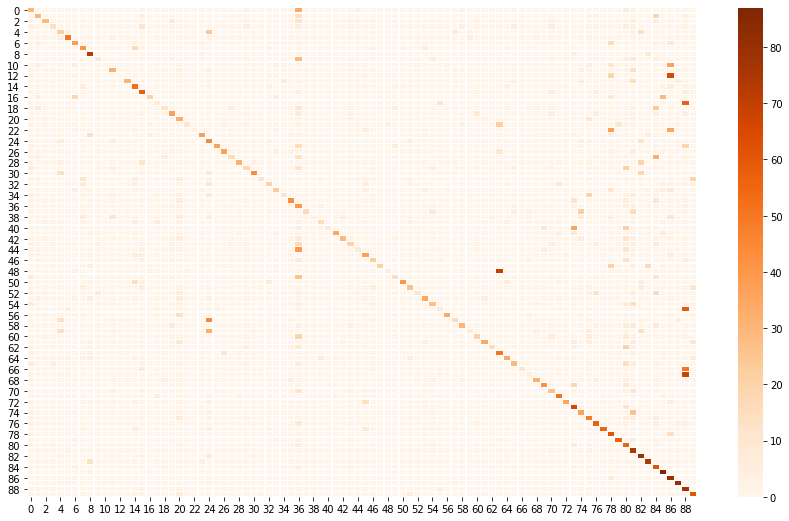

processing batch 10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12758873403072357
Step 50, Loss 0.08173993974924088
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.08173436671495438
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.0763208195567131
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.07311122119426727
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.07164645940065384
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.07031787931919098
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.07615430653095245
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.07514328509569168
Starting ep

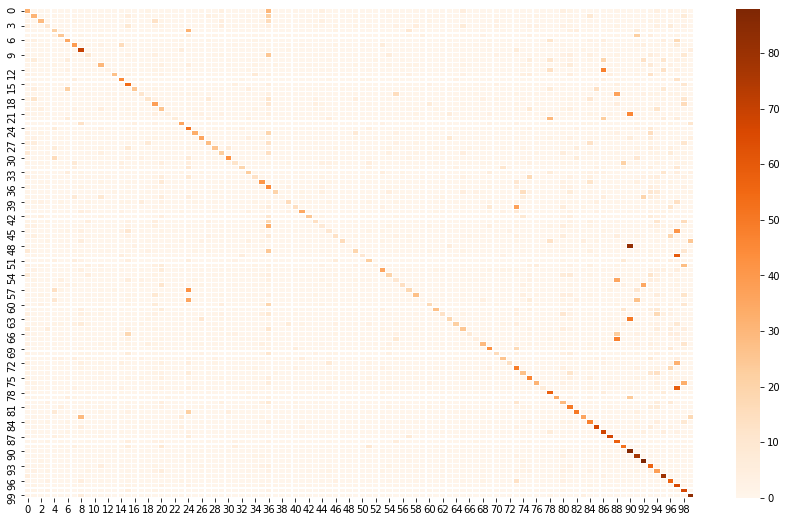

In [85]:
net = iCaRL()
K = 2000 # Memory Size
t = 0 # Number of classes
accuracies = [] # List of results 
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)

for i in range(0,10): # batches of 10
  print(f"processing batch {i+1}")
  #Create Datasets
  train_datasets = []
  train_dataset_big = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
  lbls, new_labels = make_data_labels(lbls) # take 10 new classes
  for label in new_labels:
    train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=eval_transform, download=True)
    train_dataset.increment([label],[t])
    test_dataset.increment([label],[t])
    train_dataset_big.increment([label],[t])
    train_datasets.append(train_dataset) # List of training examples in per class sets
    t += 1
  test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
  net.update_representation(train_dataset_big)
  m = K/t #numbers of exemplars per class
  matrix = new_confusion_matrix(lenx=t, leny=t)
  net.reduce_exemplar_sets(m)
  for X in train_datasets:
    print("Construct Exemplar")
    net.construct_exemplar_set(X,m) #new exemplar sets
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  # Test on Test set
  running_corrects = 0
  print("classifing")
  for images,labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    preds = net.classify(images)
    update_confusion_matrix(matrix, preds, labels)
    running_corrects += torch.sum(preds == labels.data).data.item()
    accuracy = running_corrects / float(len(test_dataset))
    del images
    del labels
    del preds
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  accuracies.append(accuracy)
  print(f"Test Accuracy: {accuracy}")
  show_confusion_matrix(matrix)

In [86]:
net.bias_layer.printParam()

0.6519388556480408 0.45813748240470886


**Define plot function**

---



In [0]:
def accuracy_plot(accuracies):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with Icarl")
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

*Print & Plot*

[0.841, 0.7055, 0.6146666666666667, 0.53375, 0.4914, 0.44783333333333336, 0.38571428571428573, 0.35775, 0.33866666666666667, 0.3109]


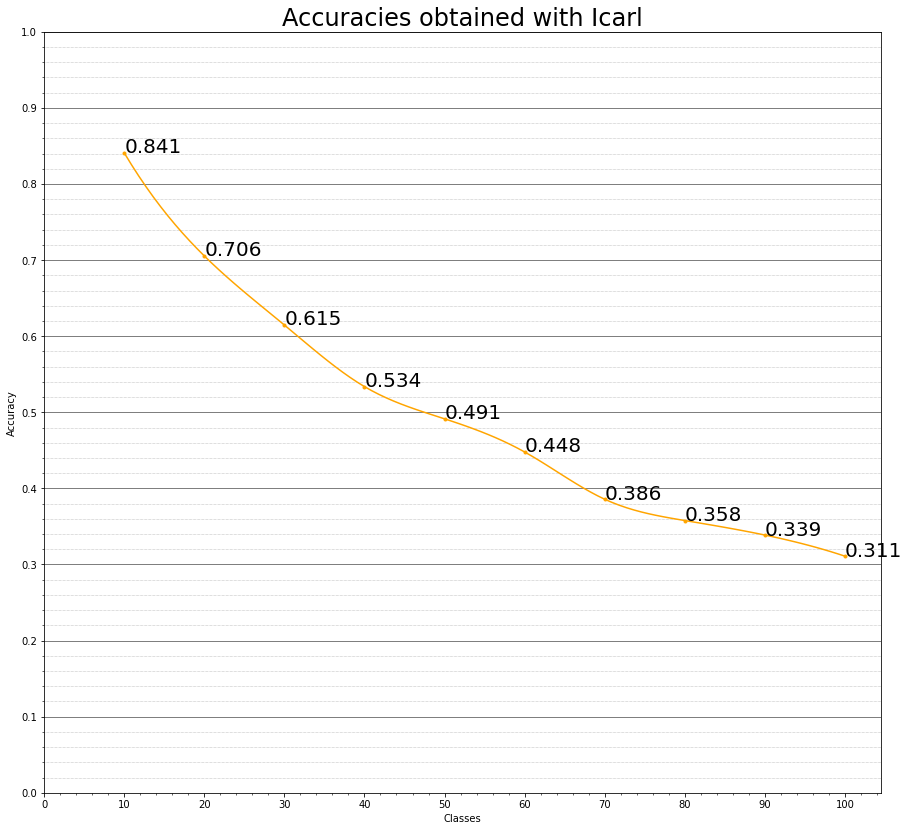

In [88]:
print(accuracies)

accuracy_plot(accuracies)
